In [ ]:
# imports

import os
import sys
sys.path.append(os.path.abspath('..'))
from rasterio.coords import BoundingBox

import src.data.preprocess_data as data
#import src.models.unets as unets

import torch

In [16]:
import geopandas as gpd
from shapely.geometry import Polygon
import random



In [ ]:
def box(x, y, patch_size, tile_size):
    if x + patch_size > tile_size:
        x = tile_size - patch_size
    if y + patch_size > tile_size:
        y = tile_size - patch_size

    if x < 0:
        x = 0
    if y < 0:
        y = 0

    return (x, y, x+patch_size, y+patch_size)

def func(patch_size = 256, tile_size = 10560, stride = None):
    if stride is None:
        stride = patch_size//2
    i = 0
    polygons = []
    inner_polygons = []
    for x in range(0, tile_size, stride):
        for y in range(0, tile_size, stride):
            xi, yi, xf, yf = box(x, y, patch_size, tile_size)
            #print(xi, xf, yi, yf)
            bbox = Polygon([(xi, yi), (xi, yf), (xf,yf), (xf, yi)])
            polygons.append(bbox)
            inner_bbox = Polygon([(xi+1, yi+1), (xi+1, yf-1), (xf-1,yf-1), (xf-1, yi+1)])
            inner_polygons.append(inner_bbox)
            
            
            i+=1
    print(i)   

    #polygons = [Polygon(coords) for coords in polygon_coords]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': polygons, 'inner_geometry': inner_polygons})
    return gdf



def random_split_gdf(gdf, sizes=[0.3, 0.3, 0.4], seed=42):
    """Randomly splits a GeoPandas DataFrame into three parts with a fixed seed.

    Args:
    gdf: The GeoPandas DataFrame to split.
    sizes: A list of three floats representing the proportion of each part.
    seed: The seed for the random number generator.

    Returns:
    A tuple of three GeoDataFrames representing the three parts.
    """

    # Set the random seed
    random.seed(seed)

    # Shuffle the DataFrame randomly
    gdf = gdf.sample(frac=1)

    # Calculate the number of rows for each part
    num_rows = len(gdf)
    num_rows_part1 = int(num_rows * sizes[0])
    num_rows_part2 = int(num_rows * sizes[1])

    # Split the DataFrame
    gdf1 = gdf.iloc[:num_rows_part1]
    gdf2 = gdf.iloc[num_rows_part1:num_rows_part1+num_rows_part2]
    gdf3 = gdf.iloc[num_rows_part1+num_rows_part2:]

    def filter_intersecting_polygons(gdf, other_gdfs, geometry_column='inner_geometry'):
        """
        Filter out polygons in gdf that intersect with any polygon in other_gdfs using the specified geometry column.
        geometry_column: Name of the geometry column to use for intersection checks.
        """
        filtered_indices = []
        for idx, geom in gdf[geometry_column].items():
            
            intersects = False
            for other_gdf in other_gdfs:
                # Create a temporary GeoDataFrame with the specified geometry column
                temp_gdf = gpd.GeoDataFrame(geometry=other_gdf[geometry_column])
                other_union = temp_gdf.union_all()
                for idx_inner, geom_inner in other_gdf[geometry_column].items():
                    if geom.intersects(geom_inner):
                        #print(geom)
                        #print(other_union)
                        intersects = True
                        break
            if not intersects:
                filtered_indices.append(idx)
        return gdf.loc[filtered_indices]
    
    gdf1_filtered = filter_intersecting_polygons(gdf, [gdf2, gdf3])
    gdf2_filtered = filter_intersecting_polygons(gdf2, [gdf3])
    gdf3_filtered = gdf3
    #gdf3_filtered = filter_intersecting_polygons(gdf3, [gdf1, gdf2])

    print(len(gdf), len(gdf2),len(gdf3))
    print(len(gdf1_filtered), len(gdf2_filtered),len(gdf3_filtered))

    return gdf1_filtered, gdf2_filtered, gdf3_filtered


#gdf = func()
gdf = func(patch_size = 10, tile_size = 1000, stride = 5)

gdf_train, gdf_val, gdf_test = random_split_gdf(gdf, sizes=[0.7, 0.15, 0.15])
print(gdf)
print(gdf_train)
print(gdf_val)
print(gdf_test)

40000


/tmp/ipykernel_34214/2957970711.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_34214/2957970711.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


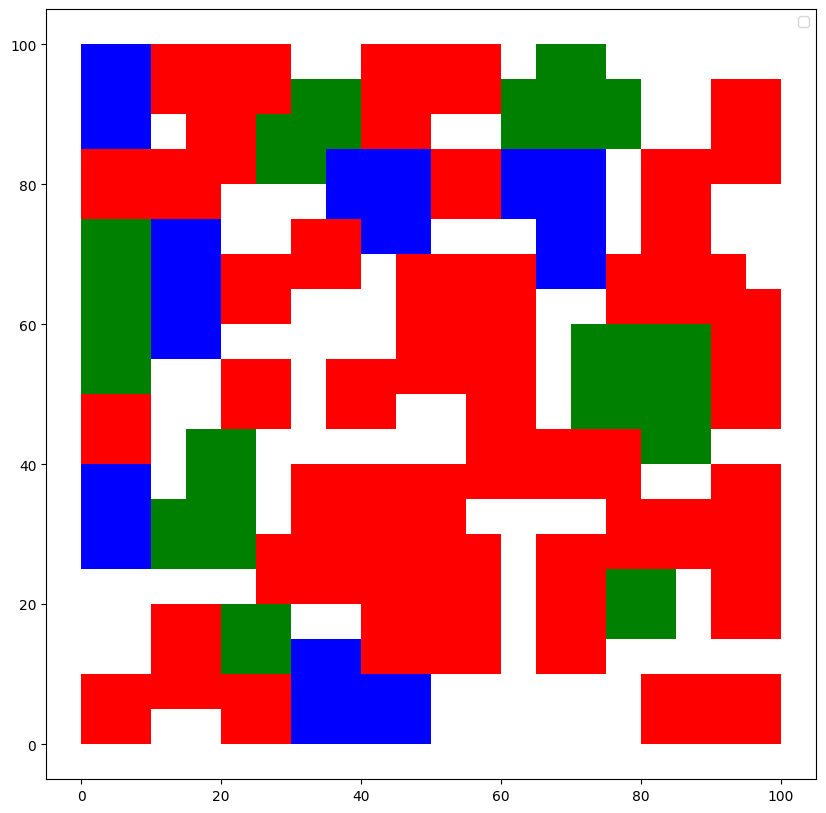

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered GeoDataFrames
gdf_train.plot(ax=ax, color='blue', label='gdf1_filtered')
gdf_val.plot(ax=ax, color='green', label='gdf2_filtered')
gdf_test.plot(ax=ax, color='red', label='gdf3_filtered')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon





# Create a list of polygons
polygons = [
    Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
    Polygon([(2, 2), (2, 3), (3, 3), (3, 2)])
]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': polygons})

# Print the GeoDataFrame
print(gdf)

In [ ]:

train_dataset = data.ImageDataset(files = train_files, 
                            mask_filename = "masks/raster_aurb_032027.tif", 
                            num_classes = num_classes,
                            subtile_size = 10560/6,
                            mean = mean, 
                            std = std,
                            patch_size = (patch_size, patch_size),
                            stride = stride,
                            augment = data_aug)